In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [106]:
# Load the dataset
data = pd.read_excel('/content/EastWestAirlines.xlsx', sheet_name='data')
data

# Display the first five rows of the dataset
print(data.head())

   ID#  Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1    28143           0          1          1          1          174   
1    2    19244           0          1          1          1          215   
2    3    41354           0          1          1          1         4123   
3    4    14776           0          1          1          1          500   
4    5    97752           0          4          1          1        43300   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0            1                  0                0               7000       0  
1            2                  0                0               6968       0  
2            4                  0                0               7034       0  
3            1                  0                0               6952       0  
4           26               2077                4               6935       1  


In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [108]:
# Data Preprocessing
# Check for missing values
print(data.isnull().sum())

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [109]:
# Scale the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, 1:])  # Exclude the ID# column
data_scaled

array([[-4.51140783e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01,  1.39545434e+00, -7.66919299e-01],
       [-5.39456874e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01,  1.37995704e+00, -7.66919299e-01],
       [-3.20031232e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01,  1.41192021e+00, -7.66919299e-01],
       ...,
       [-4.29480975e-05, -1.86298687e-01,  6.83121167e-01, ...,
        -3.62167870e-01, -1.31560393e+00,  1.30391816e+00],
       [-1.85606976e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -9.85033311e-02, -1.31608822e+00, -7.66919299e-01],
       [-7.00507951e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01, -1.31754109e+00, -7.66919299e-01]])

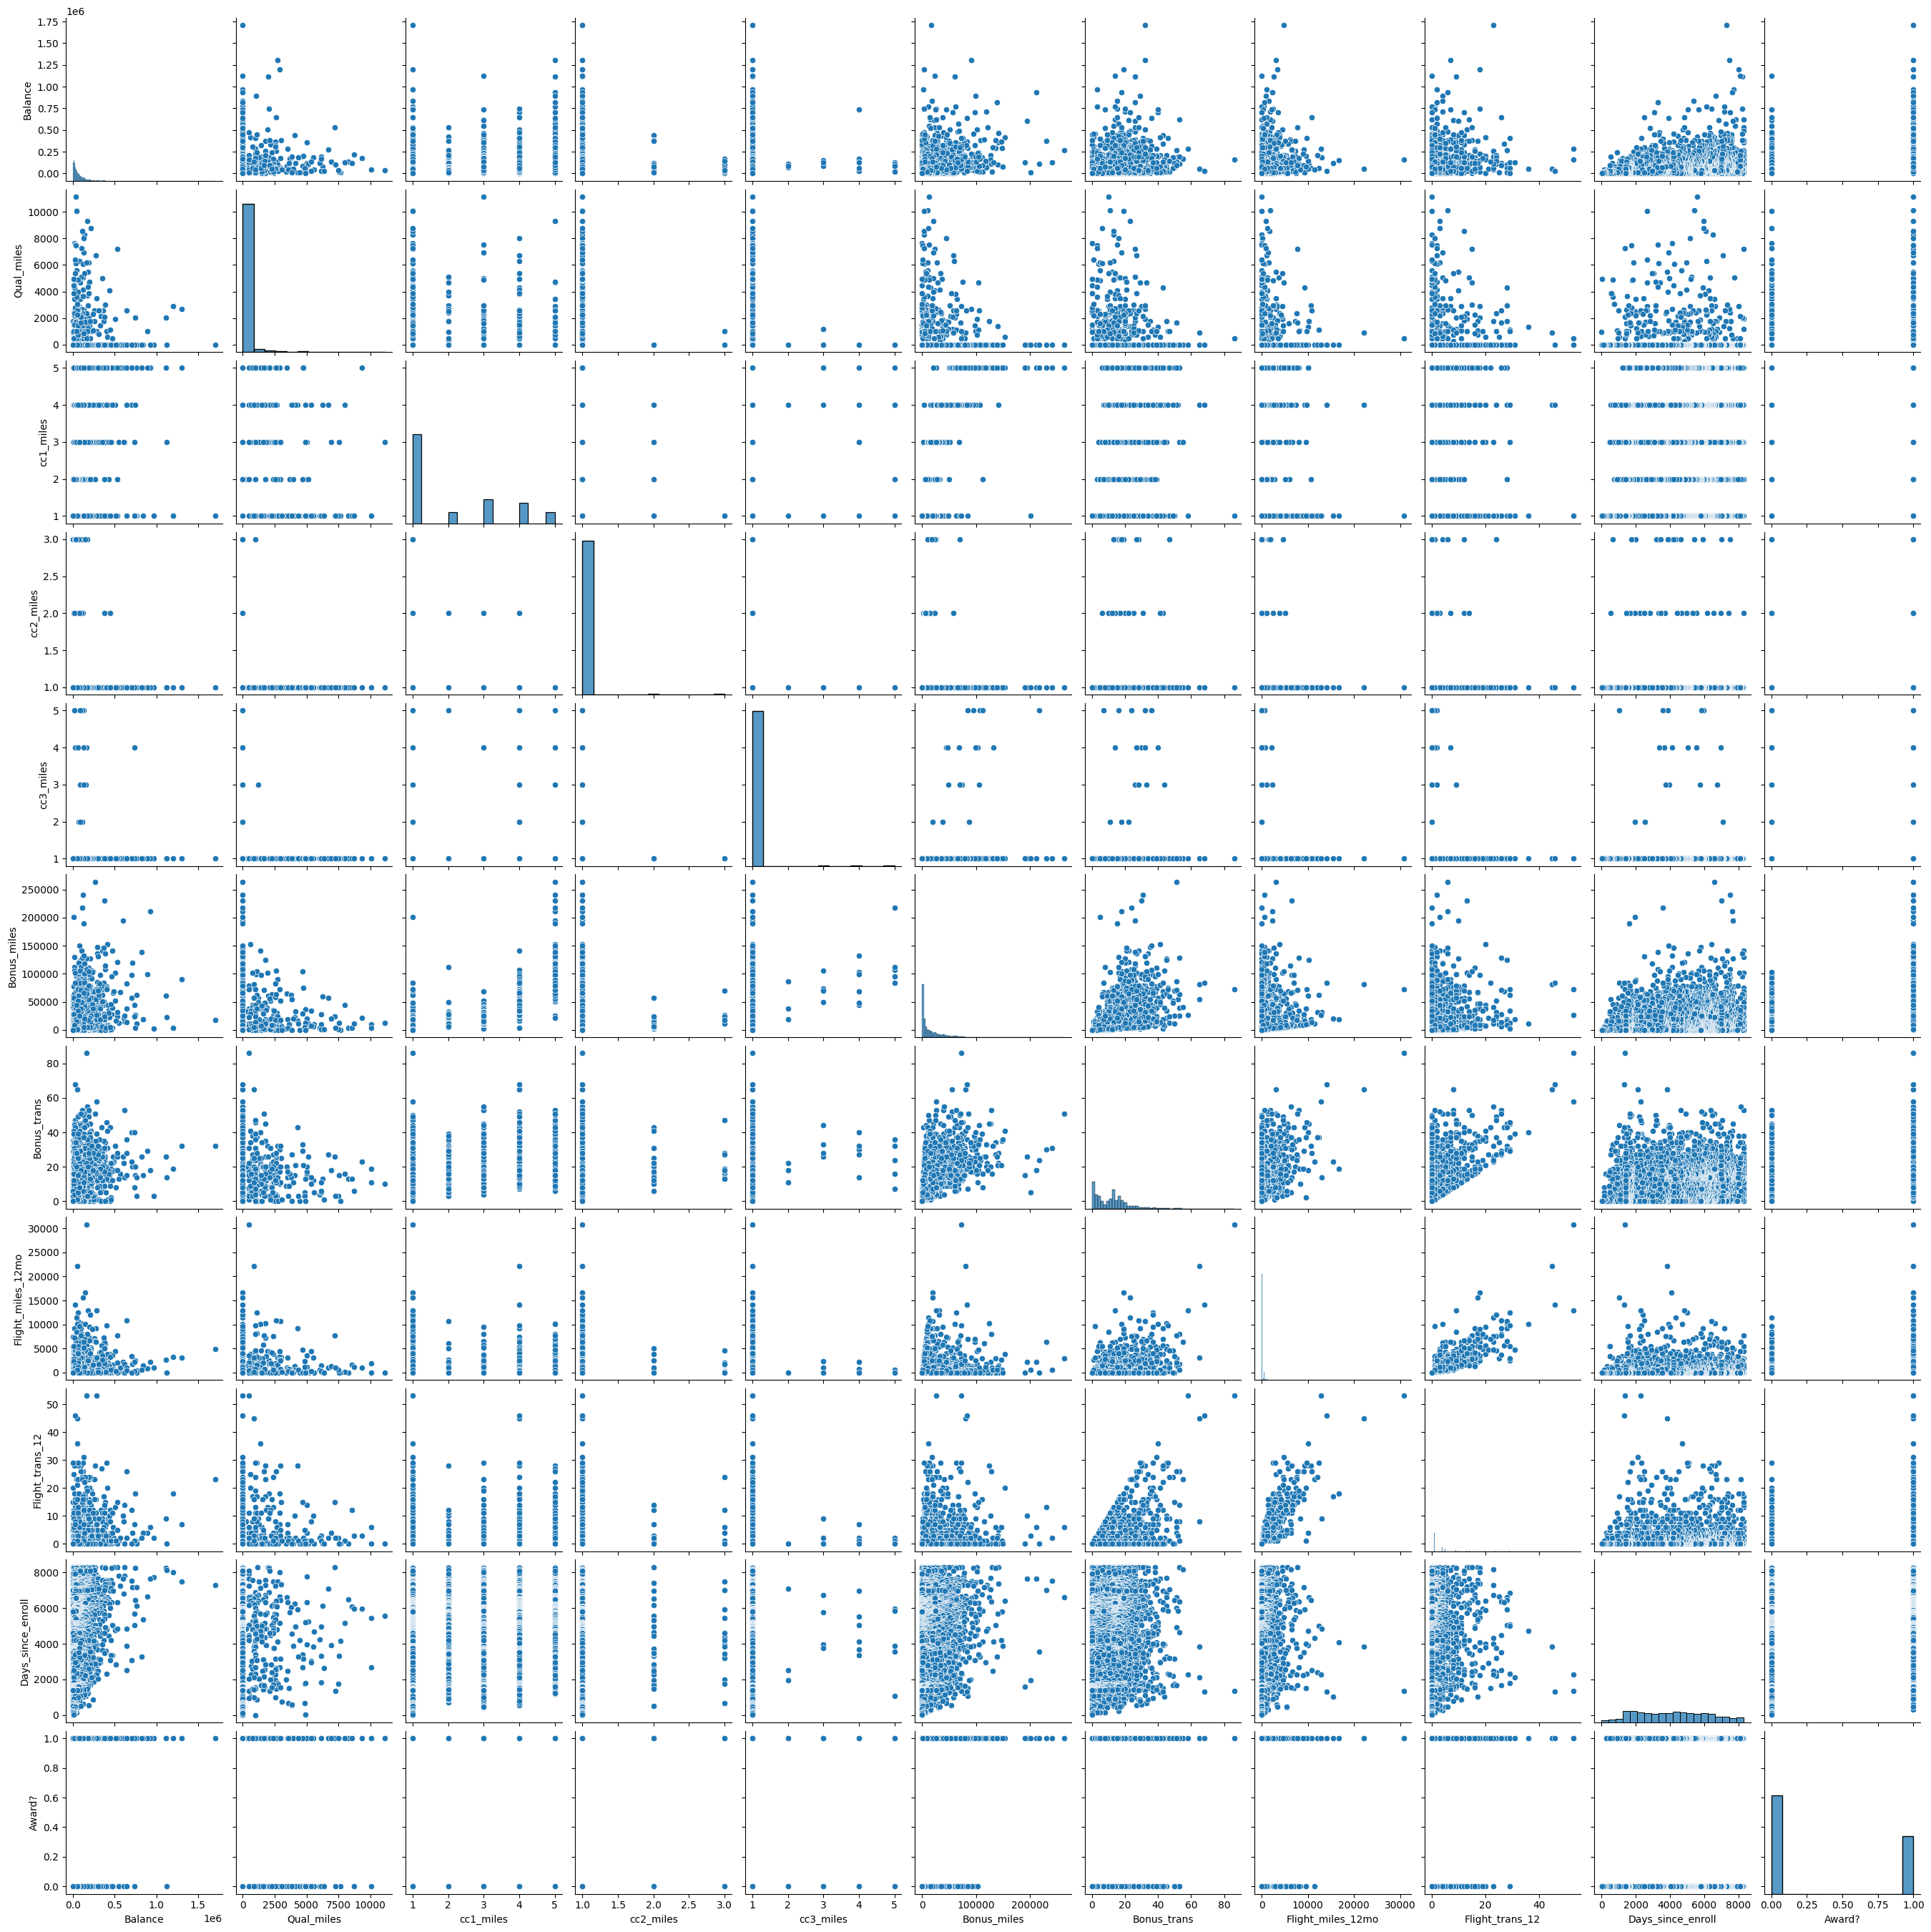

In [110]:
# Exploratory Data Analysis (EDA)
# Pairplot to visualize relationships between features
sns.pairplot(data.iloc[:, 1:])
plt.show()

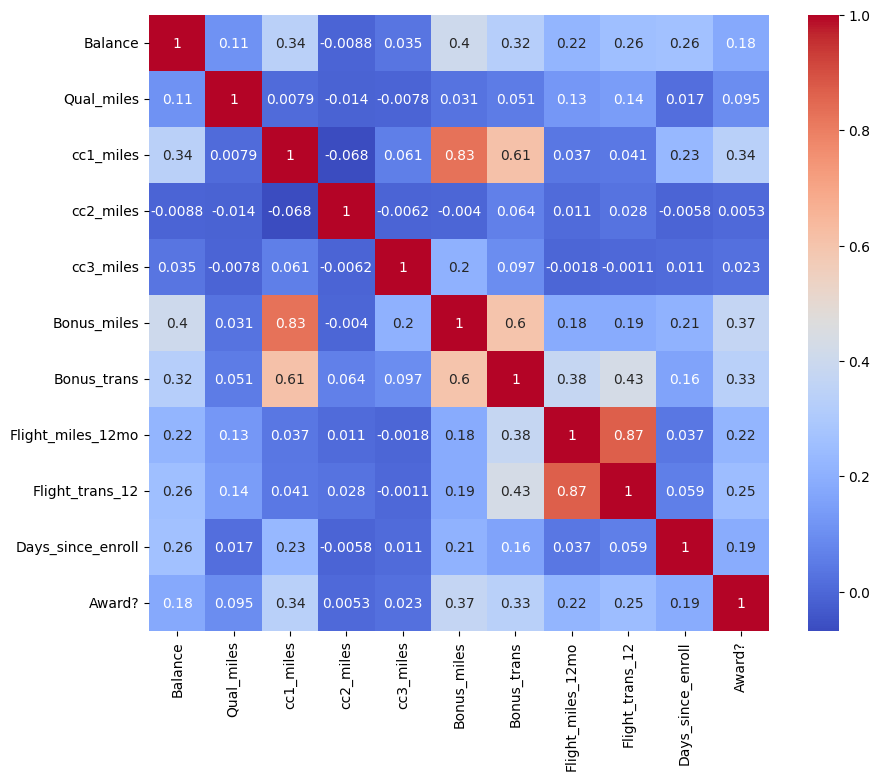

In [111]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.iloc[:, 1:].corr(), annot=True, cmap='coolwarm')
plt.show()


In [112]:
# Function to remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    data_filtered = data[(data[column] >= lower_limit) & (data[column] <= upper_limit)]
    return data_filtered

# Remove outliers for specific columns (adjust as needed)
for col in ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?']:
    data = remove_outliers_iqr(data, col)

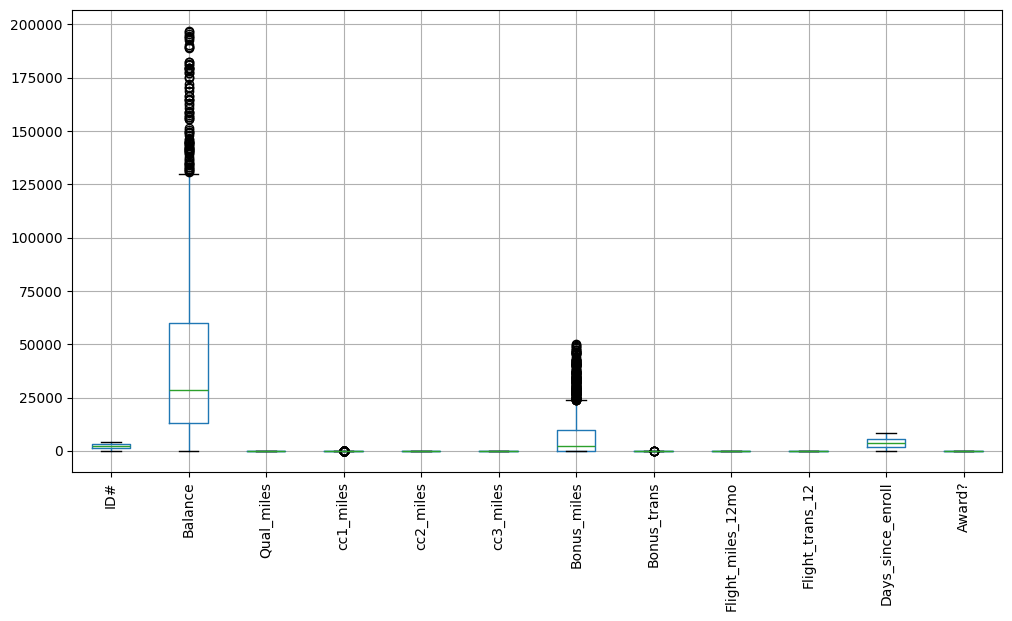

In [113]:
# Outlier Detection using Boxplots after outlier removal
plt.figure(figsize=(12, 6))
data.boxplot(rot=90)
plt.show()

In [114]:
# Rescale the data after outlier removal
data_scaled_no_outliers = scaler.fit_transform(data.iloc[:, 1:])
data_scaled_no_outliers
#kmeans_labels = kmeans.fit_predict(data_scaled_no_outliers)

array([[-0.35172951,  0.        , -0.57127092, ...,  0.        ,
         1.56649934,  0.        ],
       [-0.57351045,  0.        , -0.57127092, ...,  0.        ,
         1.5511899 ,  0.        ],
       [-0.02248486,  0.        , -0.57127092, ...,  0.        ,
         1.58276562,  0.        ],
       ...,
       [-0.7744566 ,  0.        , -0.57127092, ...,  0.        ,
        -1.1093033 ,  0.        ],
       [-0.95406951,  0.        , -0.57127092, ...,  0.        ,
        -1.1140875 ,  0.        ],
       [-0.9779448 ,  0.        , -0.57127092, ...,  0.        ,
        -1.11360908,  0.        ]])

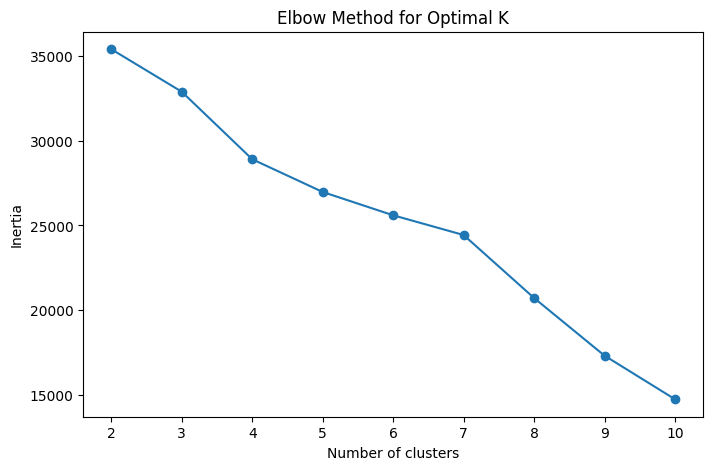

In [115]:
# Implementing Clustering Algorithms

# K-Means Clustering
# Determine the optimal number of clusters using the Elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [116]:
# Apply K-Means with the optimal number of clusters
optimal_k = 4  # Based on the Elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled_no_outliers)

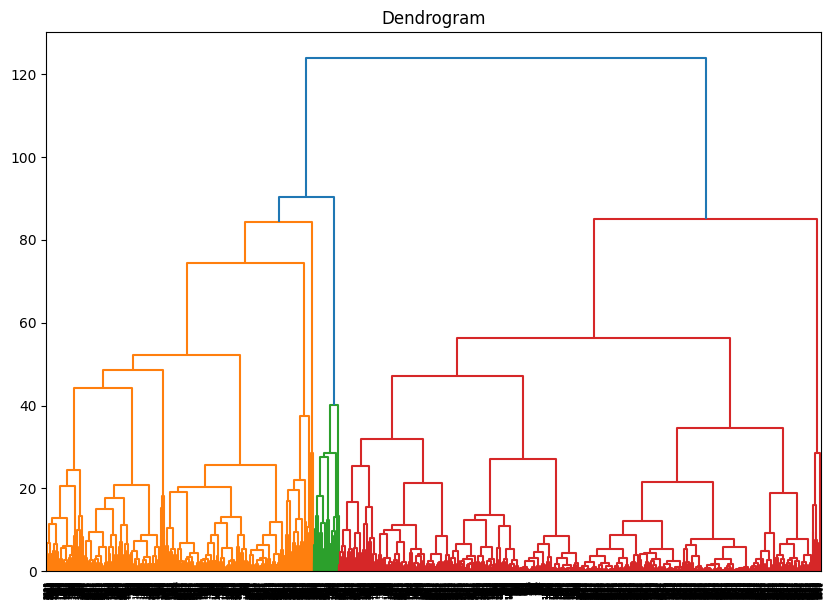

In [117]:
# Hierarchical Clustering
# Perform hierarchical clustering and plot the dendrogram
linked = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

In [118]:
# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
agglo_labels = agglo.fit_predict(data_scaled_no_outliers)

In [119]:
# DBSCAN Clustering
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled_no_outliers)

In [120]:
# Cluster Analysis and Interpretation
# Add cluster labels to the original data
data['KMeans_Cluster'] = kmeans_labels
data['Agglo_Cluster'] = agglo_labels
data['DBSCAN_Cluster'] = dbscan_labels

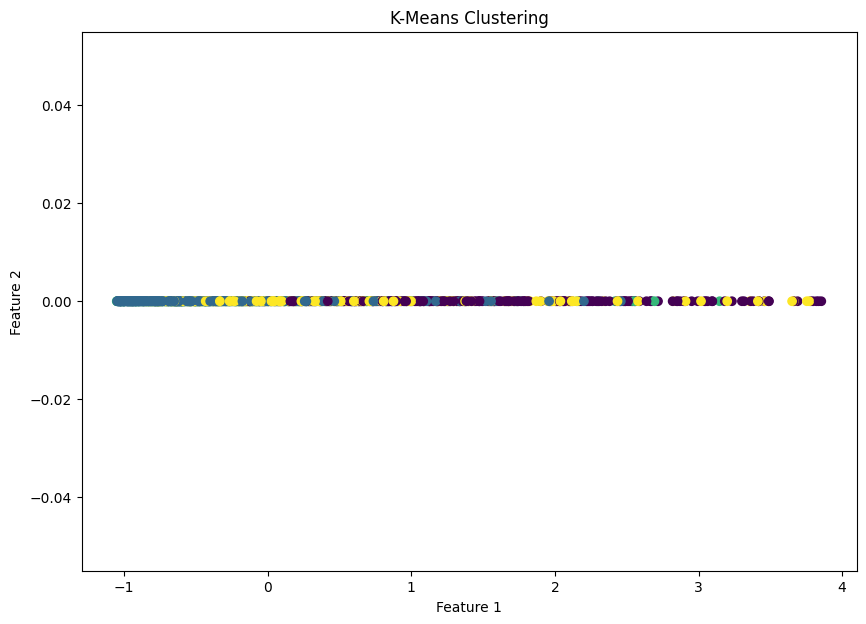

In [121]:
# Visualize the clusters
# K-Means Clustering Visualization
plt.figure(figsize=(10, 7))
plt.scatter(data_scaled_no_outliers[:, 0], data_scaled_no_outliers[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

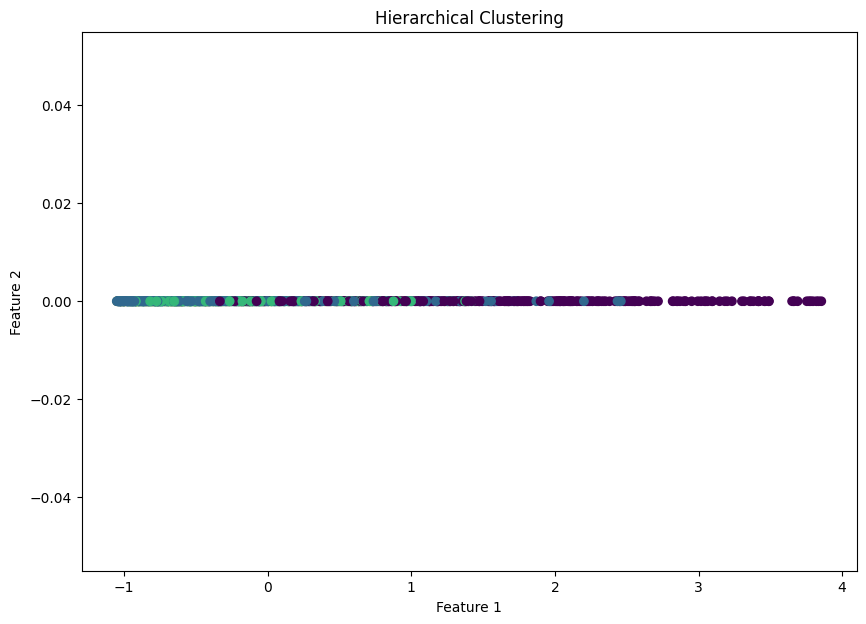

In [122]:
# Hierarchical Clustering Visualization
plt.figure(figsize=(10, 7))
plt.scatter(data_scaled_no_outliers[:, 0], data_scaled_no_outliers[:, 1], c=agglo_labels, cmap='viridis', marker='o')
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

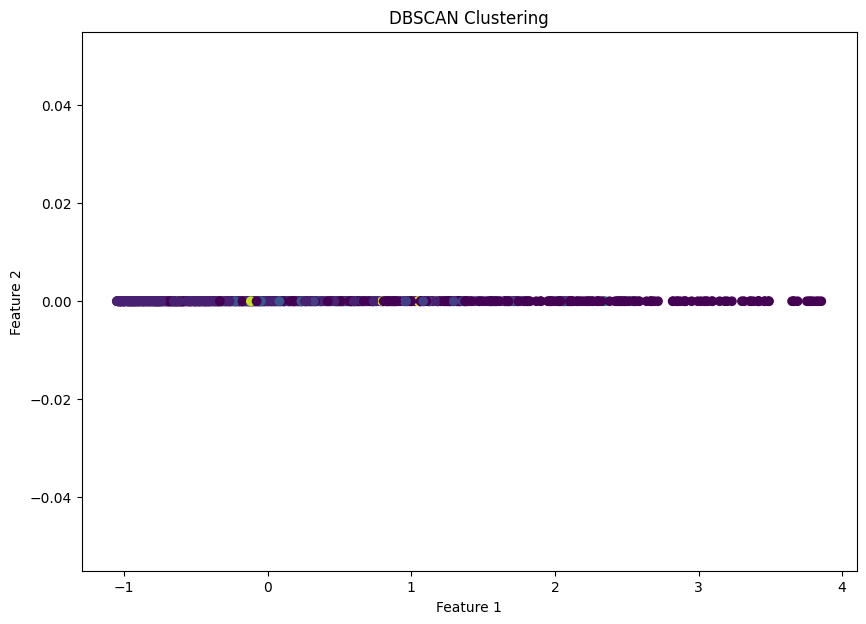

In [123]:
# DBSCAN Clustering Visualization
plt.figure(figsize=(10, 7))
plt.scatter(data_scaled_no_outliers[:, 0], data_scaled_no_outliers[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [124]:
# Evaluation and Performance Metrics
# Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(data_scaled_no_outliers, kmeans_labels)
print(f'Silhouette Score for K-Means: {kmeans_silhouette}')

Silhouette Score for K-Means: 0.3153322636550039


In [125]:
# Silhouette Score for Hierarchical Clustering
agglo_silhouette = silhouette_score(data_scaled_no_outliers, agglo_labels)
print(f'Silhouette Score for Hierarchical Clustering: {agglo_silhouette}')

Silhouette Score for Hierarchical Clustering: 0.26914614187447744


In [126]:
# Silhouette Score for DBSCAN
dbscan_silhouette = silhouette_score(data_scaled_no_outliers, dbscan_labels)
print(f'Silhouette Score for DBSCAN: {dbscan_silhouette}')


Silhouette Score for DBSCAN: -0.049536352030159124


In [127]:
# Interpretation of Clusters
# Analyze the characteristics of each cluster
for cluster in range(optimal_k):
    print(f'\nCluster {cluster} Characteristics:')
    print(data[data['KMeans_Cluster'] == cluster].describe())


Cluster 0 Characteristics:
               ID#        Balance  Qual_miles   cc1_miles  cc2_miles  \
count   337.000000     337.000000       337.0  337.000000      337.0   
mean   1734.175074   91901.272997         0.0    3.299703        1.0   
std    1064.240821   39557.792025         0.0    0.568859        0.0   
min       7.000000   25853.000000         0.0    1.000000        1.0   
25%     846.000000   62629.000000         0.0    3.000000        1.0   
50%    1739.000000   84868.000000         0.0    3.000000        1.0   
75%    2532.000000  114356.000000         0.0    4.000000        1.0   
max    4008.000000  196922.000000         0.0    4.000000        1.0   

       cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  \
count      337.0    337.000000   337.000000              337.0   
mean         1.0  25096.513353    15.228487                0.0   
std          0.0  10170.340900     4.014633                0.0   
min          1.0   3501.000000     3.000000                